In [1]:
import os
import pandas as pd
import json
import numpy as np
import seaborn as sns

from sklearn import metrics
from functools import reduce
import scipy as sp
from scipy import cluster as scl
from scipy import stats, integrate
from matplotlib import pyplot as plt
from matplotlib import gridspec as gs
import matplotlib as mpl

%matplotlib inline
sns.set(style="white")

In [2]:
def CustomParser(data):
    j1 = json.loads(data)
    return j1

In [3]:
# set path
#path_root = '/media/yassinebha/database29/Drive/QC_zooniverse_2'
#path_root = '/home/yassinebha/Drive/QC_zooniverse_2'
path_root = '/media/yassine/data_disk/Drive/QC_zooniverse_2'

In [4]:
# Read raw table and convert json to dictionary
classifications = pd.read_csv(os.path.join(path_root,'full_lunch_anat_V01/start-project-1-classifications_final.csv'), converters={'metadata':CustomParser,'annotations':CustomParser,'subject_data':CustomParser},header=0)

classifications.head()

,classification_id,user_name,user_id,user_ip,workflow_id,workflow_name,workflow_version,created_at,gold_standard,expert,metadata,annotations,subject_data,subject_ids
0,71986518,mrniaboc,107.0,48e40b5ef0f87a901437,5047,Start Project 1,1.1,2017-09-27 13:28:15 UTC,NaN,NaN,{'user_agent': 'Mozilla/5.0 (X11; Linux x86_64...,"[{'value': [], 'task': 'T1', 'task_label': 'Ta...","{'13250031': {'image1': 'X_0023027_anat.png', ...",13250031
1,71986630,mrniaboc,107.0,48e40b5ef0f87a901437,5047,Start Project 1,1.1,2017-09-27 13:28:55 UTC,NaN,NaN,{'user_agent': 'Mozilla/5.0 (X11; Linux x86_64...,"[{'value': [], 'task': 'T1', 'task_label': 'Ta...","{'13250023': {'image1': 'X_2054998_anat.png', ...",13250023
2,71986899,mrniaboc,107.0,48e40b5ef0f87a901437,5047,Start Project 1,1.1,2017-09-27 13:30:52 UTC,NaN,NaN,{'user_agent': 'Mozilla/5.0 (X11; Linux x86_64...,"[{'value': [], 'task': 'T1', 'task_label': 'Ta...","{'13250006': {'image1': 'X_3848511_anat.png', ...",13250006
3,71986947,mrniaboc,107.0,48e40b5ef0f87a901437,5047,Start Project 1,1.1,2017-09-27 13:31:12 UTC,NaN,NaN,{'user_agent': 'Mozilla/5.0 (X11; Linux x86_64...,"[{'value': [], 'task': 'T1', 'task_label': 'Ta...","{'13250035': {'image1': 'X_0010032_anat.png', ...",13250035
4,71986979,mrniaboc,107.0,48e40b5ef0f87a901437,5047,Start Project 1,1.1,2017-09-27 13:31:23 UTC,NaN,NaN,{'user_agent': 'Mozilla/5.0 (X11; Linux x86_64...,"[{'value': [], 'task': 'T1', 'task_label': 'Ta...","{'13250043': {'image1': 'X_3679455_anat.png', ...",13250043


In [5]:
classifications.count()

classification_id    4280
user_name            4280
user_id              3652
user_ip              4280
workflow_id          4280
workflow_name        4280
workflow_version     4280
created_at           4280
gold_standard           0
expert                  0
metadata             4280
annotations          4280
subject_data         4280
subject_ids          4280
dtype: int64

In [8]:
# Save jenny and cole rating for later use
# Read raw table without parsing json
classifi = pd.read_csv(os.path.join(path_root,'full_lunch_anat_V01/start-project-1-classifications_final.csv'),
                       header=0)
# Select users and save
df_jeni_cole= classifi[classifi.user_name.isin(['colezweber','ppf'])]
df_jeni_cole.to_csv(os.path.join(path_root,'full_lunch_anat_V01/jeni_cole-classifications_raw.csv'),index=False, 
                    encoding='utf-8')

In [43]:
# remove not logged in raters
#classifications = classifications[classifications.user_name.str.find("not-logged-in")==-1]
#classifications.count()

In [44]:
# extract tagging count
classifications.loc[:,"n_tagging"] = [ len(q[0]['value']) for q in classifications.annotations]
# extract rating count
classifications.loc[:,"rating"] = [ q[1]['value'] for q in classifications.annotations]
# extract subjects id
classifications.loc[:,"ID"] = [ row.subject_data[str(classifications.subject_ids[ind])]['subject_ID'] for ind,row in classifications.iterrows()]
# extract files name
classifications.loc[:,"imgnm"] = [ row.subject_data[str(classifications.subject_ids[ind])]['image1'] for ind,row in classifications.iterrows()]

In [45]:
classifications.head()

,classification_id,user_name,user_id,user_ip,workflow_id,workflow_name,workflow_version,created_at,gold_standard,expert,metadata,annotations,subject_data,subject_ids,n_tagging,rating,ID,imgnm
0,71986518,mrniaboc,107.0,48e40b5ef0f87a901437,5047,Start Project 1,1.1,2017-09-27 13:28:15 UTC,NaN,NaN,{'session': '120c9937eda62ee2c5d56c9a7561f7a4c...,"[{'task_label': 'Tag mismatched brain areas', ...","{'13250031': {'image1': 'X_0023027_anat.png', ...",13250031,0,Fail,X0023027,X_0023027_anat.png
1,71986630,mrniaboc,107.0,48e40b5ef0f87a901437,5047,Start Project 1,1.1,2017-09-27 13:28:55 UTC,NaN,NaN,{'session': '120c9937eda62ee2c5d56c9a7561f7a4c...,"[{'task_label': 'Tag mismatched brain areas', ...","{'13250023': {'image1': 'X_2054998_anat.png', ...",13250023,0,Fail,X2054998,X_2054998_anat.png
2,71986899,mrniaboc,107.0,48e40b5ef0f87a901437,5047,Start Project 1,1.1,2017-09-27 13:30:52 UTC,NaN,NaN,{'session': '120c9937eda62ee2c5d56c9a7561f7a4c...,"[{'task_label': 'Tag mismatched brain areas', ...","{'13250006': {'image1': 'X_3848511_anat.png', ...",13250006,0,Fail,X3848511,X_3848511_anat.png
3,71986947,mrniaboc,107.0,48e40b5ef0f87a901437,5047,Start Project 1,1.1,2017-09-27 13:31:12 UTC,NaN,NaN,{'session': '120c9937eda62ee2c5d56c9a7561f7a4c...,"[{'task_label': 'Tag mismatched brain areas', ...","{'13250035': {'image1': 'X_0010032_anat.png', ...",13250035,0,Fail,X0010032,X_0010032_anat.png
4,71986979,mrniaboc,107.0,48e40b5ef0f87a901437,5047,Start Project 1,1.1,2017-09-27 13:31:23 UTC,NaN,NaN,{'session': '120c9937eda62ee2c5d56c9a7561f7a4c...,"[{'task_label': 'Tag mismatched brain areas', ...","{'13250043': {'image1': 'X_3679455_anat.png', ...",13250043,0,Fail,X3679455,X_3679455_anat.png


In [46]:
# Drop unwanted rater( here 3 expert and one outlayer )
classifications = classifications[~classifications.user_name.isin(['jenichen','colezweber','ppf','willy71'])]

In [47]:
# How many rating per user
user_count = classifications.user_name.value_counts()
user_count

MsImmortal                            126
lobusparietalis                       105
1010101                               103
alinanaseer                           103
sueburr                               102
Uganalandia                           100
rubyadeline                           100
RLINDS4026                            100
hallkr                                 99
narguedasn                             95
ashherr17                              92
juliejo                                87
kitchenmi                              69
AlyPereira21                           67
ChaoticK                               54
Michaelspili                           54
alyssalewis4                           50
not-logged-in-16cc82572c6cbc0b25dc     50
Dillen                                 49
1a2r3u4n                               45
not-logged-in-e74c5c158f8c708e1ecc     44
AndrejGalinac                          44
Hmelting                               41
sanitha.yang                      

In [48]:
# drop duplicated rating
inc = 0
sum_dup = 0
for ind,user in enumerate(classifications.user_name.unique()):
    user_select_df = classifications[classifications.user_name.isin([user])]
    mask=~user_select_df.ID.duplicated()
    dup = len([m for m in mask if m == False])
    sum_dup = sum_dup+ dup
    if dup > 0 :
        print('{} have {} duplicated ratings'.format(user,dup))
    if ind == 0 and inc == 0:
        classi_unique= user_select_df[mask]
        inc+=1
    else:
        classi_unique = classi_unique.append(user_select_df[~user_select_df.ID.duplicated()])
        inc+=1
print('Total number of duplicated ratings  = {}'.format(sum_dup))

not-logged-in-e83db80fd74e90964067 have 1 duplicated ratings
hallkr have 1 duplicated ratings
not-logged-in-fdb66fc6b028a808bcac have 1 duplicated ratings
1a2r3u4n have 2 duplicated ratings
MsImmortal have 26 duplicated ratings
not-logged-in-e7dbe52af7df0907d6e9 have 3 duplicated ratings
lobusparietalis have 5 duplicated ratings
Dillen have 1 duplicated ratings
not-logged-in-d551b9dd66581a08e43c have 2 duplicated ratings
not-logged-in-75df29b7957489c3ac0e have 1 duplicated ratings
not-logged-in-e74c5c158f8c708e1ecc have 8 duplicated ratings
ritu99 have 1 duplicated ratings
1010101 have 3 duplicated ratings
not-logged-in-090f8c46cbe87b8ffe92 have 1 duplicated ratings
kitchenmi have 1 duplicated ratings
sueburr have 2 duplicated ratings
not-logged-in-d9e45923bd1328578a6a have 5 duplicated ratings
not-logged-in-16cc82572c6cbc0b25dc have 12 duplicated ratings
not-logged-in-2a6e5afcf110db2978f3 have 1 duplicated ratings
ashherr17 have 16 duplicated ratings
alinanaseer have 39 duplicated rat

In [49]:
classi_unique.count()

classification_id    3630
user_name            3630
user_id              3043
user_ip              3630
workflow_id          3630
workflow_name        3630
workflow_version     3630
created_at           3630
gold_standard           0
expert                  0
metadata             3630
annotations          3630
subject_data         3630
subject_ids          3630
n_tagging            3630
rating               3630
ID                   3630
imgnm                3630
dtype: int64

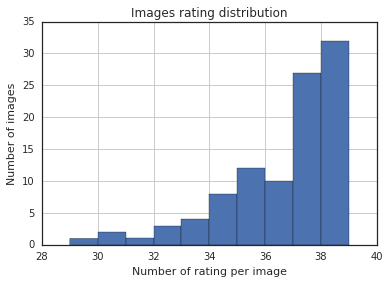

In [50]:
# Visualize images rating distribution

# subselect images 
df_ids = classi_unique.groupby(['ID']).size().reset_index(name='Count')

# sort them
df_sorted= df_ids.sort_values('Count')

# plot soted histograme
fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True)
df_ids.hist(ax = axes)
axes.set_title('Images rating distribution')
axes.xaxis.set_label_text('Number of rating per image')
axes.yaxis.set_label_text('Number of images')

In [51]:
# # remove not logged in raters
# classi_unique = classi_unique[classi_unique.user_name.str.find("not-logged-in")==-1]
# classi_unique.count()

In [70]:
#select only users that have rated a certain ammount of images 
user_count = classi_unique.user_name.value_counts()
list_user = user_count.index
list_user = list_user[user_count.values>4]
user_count[list_user]

RLINDS4026                            100
Uganalandia                           100
MsImmortal                            100
lobusparietalis                       100
rubyadeline                           100
1010101                               100
sueburr                               100
hallkr                                 98
narguedasn                             95
juliejo                                87
ashherr17                              76
kitchenmi                              68
alinanaseer                            64
ChaoticK                               54
Michaelspili                           54
alyssalewis4                           49
Dillen                                 48
AndrejGalinac                          44
AlyPereira21                           44
1a2r3u4n                               43
Hmelting                               41
sanitha.yang                           39
Service55                              39
not-logged-in-16cc82572c6cbc0b25dc

In [71]:
# remove users with less rating then the selected threshold
classi_unique = classi_unique[classi_unique.user_name.isin(list_user)]
classi_unique.count()

classification_id    3194
user_name            3194
user_id              2804
user_ip              3194
workflow_id          3194
workflow_name        3194
workflow_version     3194
created_at           3194
gold_standard           0
expert                  0
metadata             3194
annotations          3194
subject_data         3194
subject_ids          3194
n_tagging            3194
rating               3194
ID                   3194
imgnm                3194
dtype: int64

In [72]:
classifications.to_csv(os.path.join(path_root,'full_lunch_anat_V01/non_expert-project-classifications_raw.csv'))

In [106]:
#Merge Users rating
concat_rating = [classi_unique[classi_unique.user_name == user][['ID','rating']].rename(columns={'rating': user})
                  for user in list_user]
# keep unique ID's
#concats_unique = [conctat_rating[ii].ix[conctat_rating[ii].ix[:,0] ] 
#                  for ii in range(len(conctat_rating))]
df_rating = reduce(lambda left,right: pd.merge(left,right,how='outer',on='ID'), concat_rating)

In [74]:
df_rating.count()

ID                                    100
RLINDS4026                            100
Uganalandia                           100
MsImmortal                            100
lobusparietalis                       100
rubyadeline                           100
1010101                               100
sueburr                               100
hallkr                                 98
narguedasn                             95
juliejo                                87
ashherr17                              76
kitchenmi                              68
alinanaseer                            64
ChaoticK                               54
Michaelspili                           54
alyssalewis4                           49
Dillen                                 48
AndrejGalinac                          44
AlyPereira21                           44
1a2r3u4n                               43
Hmelting                               41
sanitha.yang                           39
Service55                         

In [75]:
# remove duplicates
#df_rating = df_rating[~df_rating.ID.duplicated()]

In [76]:
stuff = np.array([[row.ID,
                   np.sum(row[1:-1].values=='Fail'),
                   np.sum(row[1:-1].values=='Maybe'),
                   np.sum(row[1:-1].values=='OK')] for ind, row in df_rating.iterrows()])

In [77]:
df_score = pd.DataFrame(index=df_rating.index,data=stuff, columns=['ID','Fail', 'Maybe', 'OK'])

In [78]:
# Normalise table's row
df_score_tmp = df_score[['Fail','Maybe','OK']].astype('int')
nb_rating = df_score[['Fail','Maybe','OK']].astype('int').sum(axis="columns")
df_norm = pd.DataFrame( index=df_rating.index,columns=['ID','Fail', 'Maybe', 'OK'])
for status in ['Fail','Maybe','OK']:
    for image in df_score.index:
        df_norm[status][image] = np.int(df_score[status][image])/nb_rating[image]
        df_norm['ID'][image] = df_score['ID'][image]
# get max value
max_value = [row.iloc[1:].get_values().max() for ind,row in df_norm.iterrows()]
df_norm.loc[:,'max_value_NoExp'] = max_value
# get concensus rating
max_rate = [row.iloc[1:].idxmax(axis=1) for ind,row in df_norm.iterrows()]
df_norm.loc[:,'concensus_NoExp'] = max_rate

In [79]:
df_norm.to_csv(os.path.join(path_root,'full_lunch_anat_V01/non_expert_rating.csv'),index=False)

In [227]:
df_norm.loc[df_norm['max_value_NoExp']  <= 0.5]

,ID,Fail,Maybe,OK,max_value_NoExp,concensus_NoExp
0,X3519022,0.375,0.5,0.125,0.500000,Maybe
1,HC0040051,0.333333,0.25,0.416667,0.416667,OK
4,X1481430,0.0625,0.4375,0.5,0.500000,OK
7,X0021015,0.1875,0.46875,0.34375,0.468750,Maybe
8,X0026022,0.176471,0.441176,0.382353,0.441176,Maybe
9,X0026024,0.151515,0.454545,0.393939,0.454545,Maybe
12,X1038415,0.206897,0.448276,0.344828,0.448276,Maybe
20,X1647968,0.133333,0.5,0.366667,0.500000,Maybe
22,X2920716,0.433333,0.233333,0.333333,0.433333,Fail
23,X0021018,0.34375,0.15625,0.5,0.500000,OK


In [305]:
def sample_dataframe(df,perc,seed=0):
    ''' 
    Randomly select a subset of dataframe
    input
        df:  a adtaframe object 
        perc: percentage of date to be subseted<
    output
        df_subSamp: subsetted dataframe
        msk: boolean mask of subsetted value
    '''
    np.random.seed(seed)
    msk = np.random.rand(len(df)) < perc
    df_subSamp = df[msk]
    return df_subSamp,msk

In [295]:
def select_users(df,thresh):
    '''
    select only users that have rated a certain ammount of images
    '''
    user_count = df.user_name.value_counts()
    list_user = user_count.index
    list_user = list_user[user_count.values>thresh]
    return list_user
    

In [296]:
def merge_users_rating(df,list_user):
    #Merge Users rating
    concat_rating = [df[df.user_name == user][['ID','rating']].rename(columns={'rating': user})
                      for user in list_user]
    df_rating = reduce(lambda left,right: pd.merge(left,right,how='outer',on='ID'), concat_rating)
    # make new dataframe out of merged ratings
    stuff = np.array([[row.ID,
                   np.sum(row[1:-1].values=='Fail'),
                   np.sum(row[1:-1].values=='Maybe'),
                   np.sum(row[1:-1].values=='OK')] for ind, row in df_rating.iterrows()])
    df_score = pd.DataFrame(index=df_rating.index,data=stuff, columns=['ID','Fail', 'Maybe', 'OK'])
    return df_score,df_rating

In [297]:
def normalize_rating(df_score,df_rating):
    # Normalise table's row
    df_score_tmp = df_score[['Fail','Maybe','OK']].astype('int')
    nb_rating = df_score[['Fail','Maybe','OK']].astype('int').sum(axis="columns")
    df_norm = pd.DataFrame( index=df_rating.index,columns=['ID','Fail', 'Maybe', 'OK'])
    for status in ['Fail','Maybe','OK']:
        for image in df_score.index:
            df_norm[status][image] = np.int(df_score[status][image])/nb_rating[image]
            df_norm['ID'][image] = df_score['ID'][image]
    # get max value
    max_value = [row.iloc[1:].get_values().max() for ind,row in df_norm.iterrows()]
    df_norm.loc[:,'max_value_NoExp_t'] = max_value
    # get concensus rating
    max_rate = [row.iloc[1:].idxmax(axis=1) for ind,row in df_norm.iterrows()]
    df_norm.loc[:,'concensus_NoExp_t'] = max_rate
    return(df_norm)

In [298]:
def visu_rating_img_dist(df,title):
    # Visualize images rating distribution
    # subselect images 
    df_ids = df.groupby(['ID']).size().reset_index(name='Count')
    # sort them
    df_sorted= df_ids.sort_values('Count')
    # plot soted histograme
    fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True)
    df_ids.hist(ax = axes)
    axes.set_title(title)
    axes.xaxis.set_label_text('Number of rating per image')
    axes.yaxis.set_label_text('Number of images')

In [350]:
#split half kappa estimate
df_subSamp_1,msk = sample_dataframe(classi_unique,0.5,134)
df_subSamp_2=classi_unique[~msk]
list_user_1 = select_users(df_subSamp_1,0)
list_user_2 =  select_users(df_subSamp_2,0)
df_merge_rater_1,df_subRater_1 = merge_users_rating(df_subSamp_1,list_user_1)
df_merge_rater_2,df_subRater_2 = merge_users_rating(df_subSamp_2,list_user_2)
df_merge_rater_norm_1 = normalize_rating(df_merge_rater_1,df_subRater_1)
df_merge_rater_norm_2 = normalize_rating(df_merge_rater_2,df_subRater_2)

# generate concensus table
df_kappa_tmp =df_merge_rater_norm_1[['ID','concensus_NoExp_t']].merge(df_merge_rater_norm_2[['ID','concensus_NoExp_t']],
                                                                    how='left',
                                                                    on='ID')
df_kappa_tmp.replace({'OK':1,'Maybe':2, 'Fail':3}, inplace=True)
df_kappa_tmp.dropna(inplace=True)

In [351]:
rater1 = df_kappa_tmp['concensus_NoExp_t_x']

In [352]:
rater2 = df_kappa_tmp['concensus_NoExp_t_y']

In [353]:
metrics.cohen_kappa_score(rater1,rater2)

0.52911630827185685

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in long_scalars
  


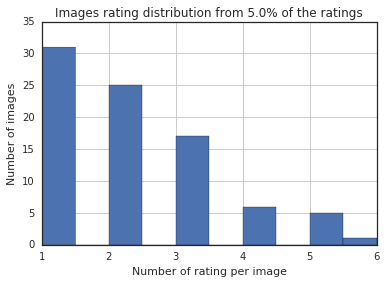

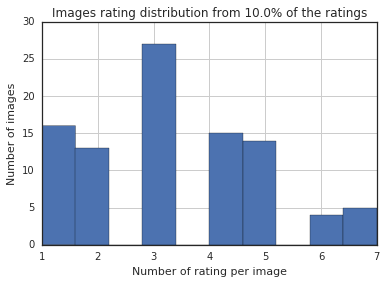

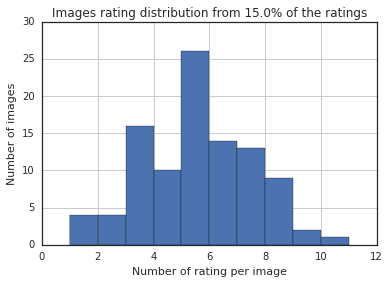

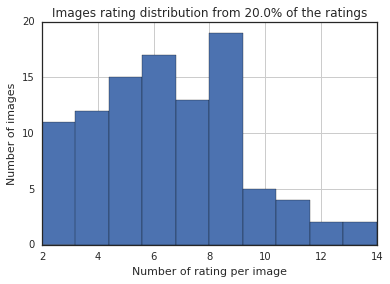

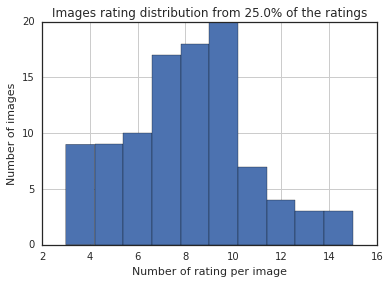

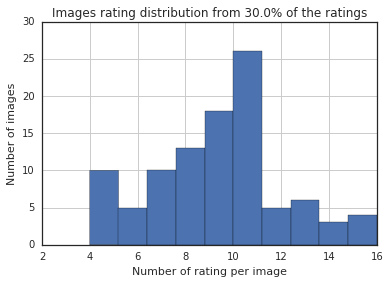

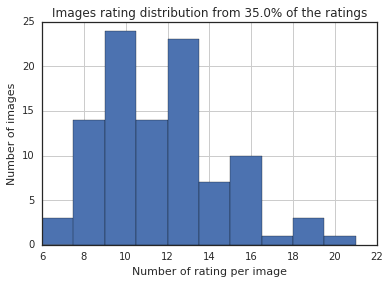

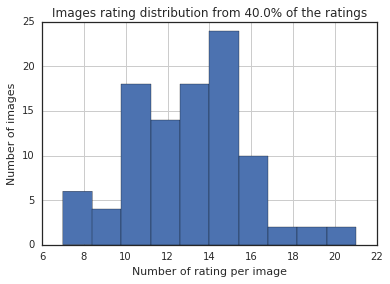

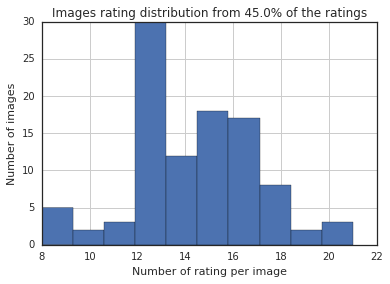

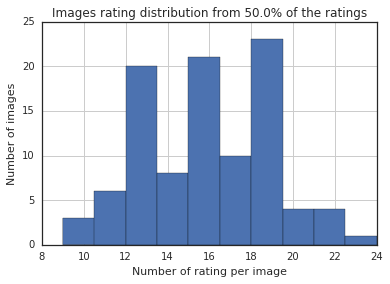

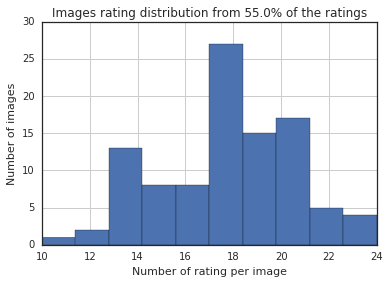

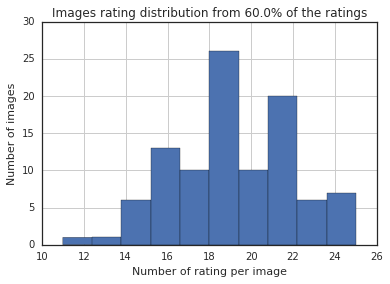

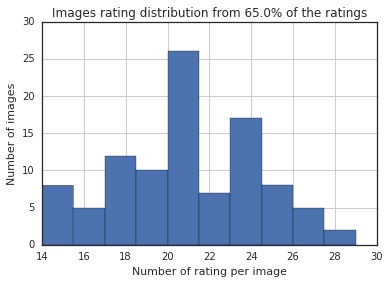

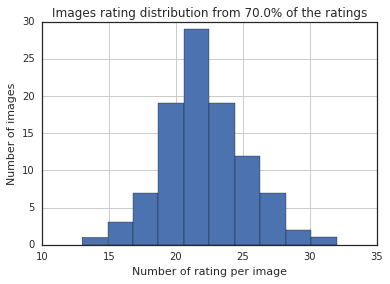

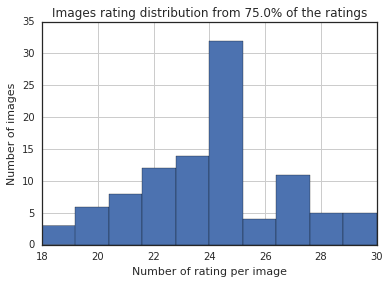

In [256]:

sample_range = np.arange(0.05,0.8,0.05)
kappa_array = np.zeros((len(sample_range), 1))
for ind, val in enumerate(sample_range):
    # subset dataframe
    df_subSamp,msk = sample_dataframe(classi_unique,val)
    visu_rating_img_dist(df_subSamp,'Images rating distribution from {:.1f}% of the ratings'.format(val*100))
    list_user_t = select_users(df_subSamp,0)
    df_merge_rater,df_subRater = merge_users_rating(df_subSamp,list_user_t)
    df_merge_rater_norm = normalize_rating(df_merge_rater,df_subRater)
    
    # generate concensus table
    df_kappa_tmp =df_merge_rater_norm[['ID','concensus_NoExp_t']].merge(df_norm[['ID','concensus_NoExp']],
                                                                    how='left',
                                                                    on='ID')
    df_kappa_tmp.replace({'OK':1,'Maybe':2, 'Fail':3}, inplace=True)
    df_kappa_tmp.dropna(inplace=True)
    
    # Generate Kappa erray
    rater_1 = df_kappa_tmp['concensus_NoExp']
    rater_2 = df_kappa_tmp['concensus_NoExp_t']
    kappa = metrics.cohen_kappa_score(rater_1,rater_2)
    kappa_array[ind] = kappa
    

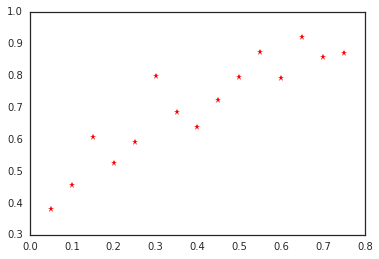

In [258]:
plt.plot(sample_range,kappa_array,'r*')

In [188]:
df_subSamp,msk = sample_dataframe(classi_unique,0.5)

In [189]:
df_subSamp.count()

classification_id    1615
user_name            1615
user_id              1427
user_ip              1615
workflow_id          1615
workflow_name        1615
workflow_version     1615
created_at           1615
gold_standard           0
expert                  0
metadata             1615
annotations          1615
subject_data         1615
subject_ids          1615
n_tagging            1615
rating               1615
ID                   1615
imgnm                1615
dtype: int64

In [168]:
df_kappa_tmp =df_merge_rater_norm[['ID','concensus_NoExp_t']].merge(df_norm[['ID','concensus_NoExp']],
                                                                    how='left',
                                                                    on='ID')
df_kappa_tmp.replace({'OK':1,'Maybe':2, 'Fail':3}, inplace=True)
df_kappa_tmp.dropna(inplace=True)

In [155]:



# Generate Kappa erray
rater_1 = df_kappa_tmp['concensus_NoExp']
rater_2 = df_kappa_tmp['concensus_NoExp_t']
kappa = metrics.cohen_kappa_score(df_kappa[[rater_1]],df_kappa[[rater_2]])
# Save the kappa
kappa_store[net_id, s_id] = kappa

#### Histograms
Histograms of the frequency of the "OK", "Maybe" and "fail" rating across raters, for all images. If all raters agreed, we would only have 0% or 100% rating frequencies. 

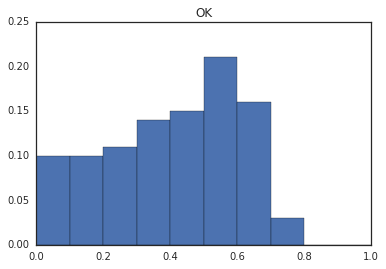

In [67]:
#### Histogram of OK
hok , bins = np.histogram(df_norm.OK,bins=np.arange(0,1.1,0.1))
hok = hok.astype(np.float32) / hok.sum()
plt.bar(bins[:-1], hok , width=(bins[1]-bins[0]))
plt.title('OK')

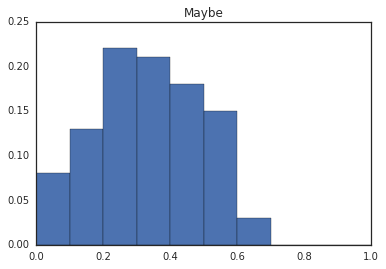

In [34]:
# Histogram of Maybe
hmaybe , bins = np.histogram(df_norm.Maybe,bins=np.arange(0,1.1,0.1))
hmaybe = hmaybe.astype(np.float32) / hmaybe.sum()
plt.bar(bins[:-1], hmaybe , width=(bins[1]-bins[0]))
plt.title('Maybe')

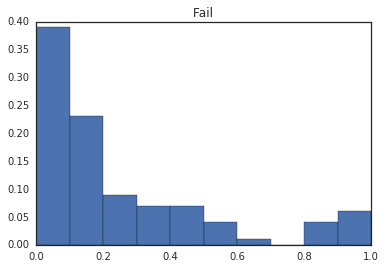

In [35]:
# Histogram of Fail
hfail , bins = np.histogram(df_norm.Fail,bins=np.arange(0,1.1,0.1))
hfail = hfail.astype(np.float32) / hfail.sum()
plt.bar(bins[:-1], hfail , width=(bins[1]-bins[0]))
plt.title('Fail')

## Kappa score

In [36]:
# filter user who completed rating for kappa
name_users_kappa = [ix for ix,x in user_count.iteritems() if x >= 65]


In [37]:
#select raters
df_kappa = df_rating[["ID"]+ name_users_kappa]
df_kappa.count()

ID                 100
lobusparietalis    100
1010101            100
rubyadeline        100
Uganalandia        100
sueburr            100
RLINDS4026         100
MsImmortal         100
willy71            100
hallkr              98
narguedasn          95
juliejo             87
ashherr17           76
kitchenmi           68
dtype: int64

In [38]:
# add matching column 
df_kappa.loc[:,"rating_match"] = df_kappa.iloc[:,1:].apply(lambda x: len(set(x)) == 1, axis=1)

/usr/local/lib/python3.5/dist-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.5/dist-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [39]:
df_kappa.head()

,ID,lobusparietalis,1010101,rubyadeline,Uganalandia,sueburr,RLINDS4026,MsImmortal,willy71,hallkr,narguedasn,juliejo,ashherr17,kitchenmi,rating_match
0,X1743472,Maybe,Maybe,Fail,Fail,Maybe,Maybe,Fail,Maybe,Fail,Maybe,Fail,Fail,Fail,False
1,X3662296,Maybe,OK,OK,Maybe,Maybe,Fail,Fail,Fail,Fail,Maybe,Maybe,Maybe,Fail,False
2,X2443191,OK,OK,OK,OK,Fail,Maybe,OK,OK,OK,OK,OK,OK,NaN,False
3,HC0040055,OK,OK,OK,OK,Maybe,OK,OK,OK,Maybe,OK,OK,OK,NaN,False
4,X4104523,Maybe,Fail,OK,Fail,Maybe,Fail,Fail,OK,OK,OK,Maybe,NaN,NaN,False


In [40]:
# Add concensus rating
df_kappa=df_kappa.merge(df_norm[['ID','concensus_NoExp']],how='left',on='ID')
# add concensus rating in the user list
name_users_kappa.append('concensus_NoExp')

In [41]:
df_kappa.dropna(inplace=True)

In [42]:
df_kappa.count()

ID                 44
lobusparietalis    44
1010101            44
rubyadeline        44
Uganalandia        44
sueburr            44
RLINDS4026         44
MsImmortal         44
willy71            44
hallkr             44
narguedasn         44
juliejo            44
ashherr17          44
kitchenmi          44
rating_match       44
concensus_NoExp    44
dtype: int64

In [43]:
# Replace OK:1 , Maybe:2 and Fail:3
df_kappa.replace({'OK':1,'Maybe':2, 'Fail':3}, inplace=True)
df_kappa.head()

,ID,lobusparietalis,1010101,rubyadeline,Uganalandia,sueburr,RLINDS4026,MsImmortal,willy71,hallkr,narguedasn,juliejo,ashherr17,kitchenmi,rating_match,concensus_NoExp
0,X1743472,2,2,3,3,2,2,3,2,3,2,3,3,3,False,3
1,X3662296,2,1,1,2,2,3,3,3,3,2,2,2,3,False,3
6,X2415970,1,1,1,1,2,2,2,1,1,1,1,1,1,False,1
7,X2876903,1,1,1,2,2,2,2,1,1,2,1,2,3,False,2
9,HC0040056,1,2,1,1,2,1,2,2,1,1,1,1,2,False,1


In [44]:
# remove duplicates ID's
df_kappa = df_kappa[~df_kappa.ID.duplicated()]# remove duplicates ID's
df_kappa = df_kappa[~df_kappa.ID.duplicated()]
df_kappa.count()

ID                 44
lobusparietalis    44
1010101            44
rubyadeline        44
Uganalandia        44
sueburr            44
RLINDS4026         44
MsImmortal         44
willy71            44
hallkr             44
narguedasn         44
juliejo            44
ashherr17          44
kitchenmi          44
rating_match       44
concensus_NoExp    44
dtype: int64

In [45]:
# calculate the percentage of agreement
agreem_num = (df_kappa.rating_match.sum()/df_kappa.ID.count())*100
"The percentage of agreement is: {:.2f}".format(agreem_num)

'The percentage of agreement is: 2.27'

In [46]:
# Generate Kappa matrix rater by rater
kappa_store = np.zeros((len(name_users_kappa), len(name_users_kappa)))
for net_id in range(len(name_users_kappa)):
    rater_1 = name_users_kappa[net_id]
    for s_id in range(len(name_users_kappa)):
        rater_2 = name_users_kappa[s_id]
        kappa = metrics.cohen_kappa_score(df_kappa[[rater_1]],df_kappa[[rater_2]])
        # Save the kappa
        kappa_store[net_id, s_id] = kappa

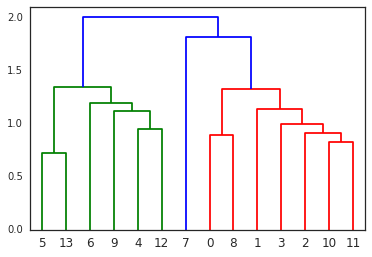

In [47]:
# cluster and order kappa matrix
dist = sp.spatial.distance.pdist(kappa_store)
link = scl.hierarchy.linkage(dist, method='ward')
order = scl.hierarchy.dendrogram(link, no_plot=False)['leaves']
part = scl.hierarchy.fcluster(link, 3, criterion='maxclust')

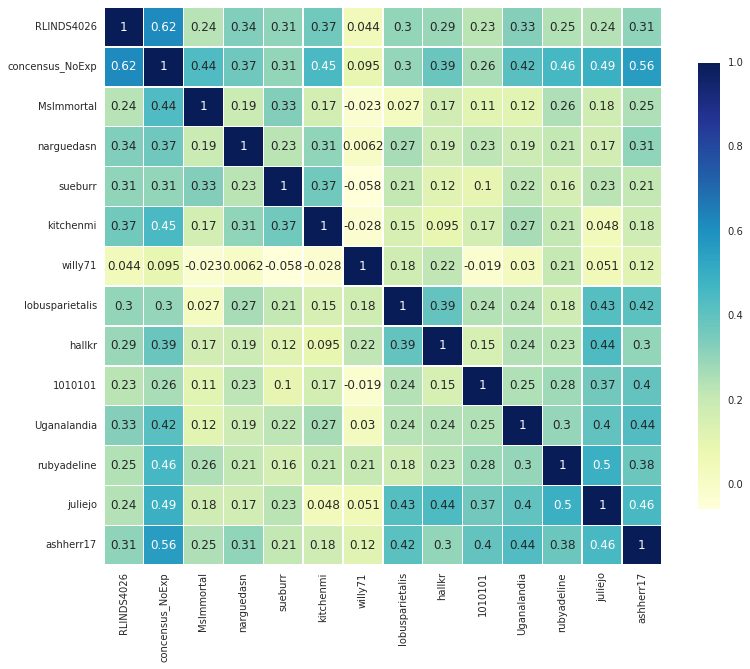

In [48]:
# Plot kappa matrix
kappa_out = pd.DataFrame(kappa_store[order, :][:, order], 
                         index=[name_users_kappa[ord] for ord in order],
                         columns=[name_users_kappa[ord] for ord in order])
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(13, 10))
# Draw the map
sns.heatmap(kappa_out,vmax=1,cmap="YlGnBu",
            square=True,annot=True,
            linewidths=.5, cbar_kws={"shrink": .8}, ax=ax)

In [127]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://i.stack.imgur.com/kYNd6.png" ,width=600, height=600)

## Plot tagging on images 

In [128]:
%matplotlib inline
import os
import matplotlib
import matplotlib.pyplot as plt

In [129]:
#base_path = '/home/yassinebha/Drive/QC_zooniverse_2/brainhack2017/rating_images'

In [130]:
# output markings from 50 classifications
#Basile
clist=[]
for index, c in classifications.iterrows():
    if c['n_tagging'] > 0:
        for q in c.annotations[0]['value']:
            clist.append({'ID':c.ID, 'workflow_name':c.workflow_name,'user_name':c.user_name, 'rating':c.rating,'imgnm':c.imgnm, 
                          'x':q['x'], 'y':np.round(q['y']).astype(int), 'r':'2','n_tagging':c.n_tagging ,'frame':q['frame']})
    else:
        clist.append({'ID':c.ID, 'workflow_name':c.workflow_name, 'user_name':c.user_name,'rating':c.rating,'imgnm':c.imgnm, 
                          'x':float('nan'), 'y':float('nan'), 'r':float('nan'),'n_tagging':c.n_tagging ,'frame':'1'})

col_order=['ID','workflow_name','user_name','rating','x','y','r','n_tagging','imgnm','frame']
out = pd.DataFrame(clist)[col_order]

In [131]:
out.head()

,ID,workflow_name,user_name,rating,x,y,r,n_tagging,imgnm,frame
0,X2030383,Start Project 1,H_Spiers,OK,NaN,NaN,NaN,0,X_2030383_anat.png,1
1,X3163200,Start Project 1,H_Spiers,Fail,92.96875,65.0,2,9,X_3163200_anat.png,0
2,X3163200,Start Project 1,H_Spiers,Fail,331.96875,62.0,2,9,X_3163200_anat.png,0
3,X3163200,Start Project 1,H_Spiers,Fail,533.96875,18.0,2,9,X_3163200_anat.png,0
4,X3163200,Start Project 1,H_Spiers,Fail,330.96875,283.0,2,9,X_3163200_anat.png,0


In [132]:
# out only selected rater
out_kappa = out.loc[out['user_name'].isin(name_users_kappa)]
# out only kappa rated images
out_kappa = out_kappa.loc[out_kappa['ID'].isin(df_kappa.ID)]
out_kappa.head()

,ID,workflow_name,user_name,rating,x,y,r,n_tagging,imgnm,frame
17,X3912996,Start Project 1,rubyadeline,Maybe,285.96875,199.0,2,2,X_3912996_anat.png,0
18,X3912996,Start Project 1,rubyadeline,Maybe,313.96875,556.0,2,2,X_3912996_anat.png,0
73,X1038415,Start Project 1,rubyadeline,OK,NaN,NaN,NaN,0,X_1038415_anat.png,1
77,X2854839,Start Project 1,rubyadeline,Maybe,131.96875,180.0,2,3,X_2854839_anat.png,0
78,X2854839,Start Project 1,rubyadeline,Maybe,190.96875,631.0,2,3,X_2854839_anat.png,0


In [133]:
ids_imgnm = np.reshape([out.ID.unique(),out.imgnm.unique()],(2,np.shape(out.ID.unique())[0]))

In [68]:
from shutil import copyfile, copy2
#base_path_src = os.path.join(path_root,'zooqc_report_adhd_03-Jul-2017/registration')
base_path_src = os.path.join(path_root,'zooqc_report_cobre_03-Jul-2017/registration')
base_path_dest = os.path.join(path_root,'Beta2/rating_images')

In [69]:
# juste run once to collect images in specific folder
#from shutil import copyfile, copy2
#base_path_src = os.path.join(path_root,'zooqc_report_adhd_03-Jul-2017/registration')
#base_path_src = os.path.join(path_root,'zooqc_report_cobre_03-Jul-2017/registration')
#base_path_dest = os.path.join(path_root,'Beta2/rating_images')
#for ii in np.sort(ids_imgnm.T[:,1])[:15]:#[15:]
    #print(ii)
    #copy2(os.path.join(base_path_src,ii),base_path_dest)

In [70]:
df_ids_imgnm = pd.DataFrame(np.sort(ids_imgnm.T, axis=0),columns=['ID', 'imgnm'])

In [71]:
df_ids_imgnm.count()

ID       100
imgnm    100
dtype: int64

In [78]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib
from PIL import Image
def _cmap_from_image_path(img_path):
        img = Image.open(img_path)
        img = img.resize((256, img.height))
        colours = (img.getpixel((x, 0)) for x in range(256))
        colours = [(r/255, g/255, b/255, a/255) for (r, g, b, a) in colours]
        return colours,LinearSegmentedColormap.from_list('from_image', colours)

In [79]:
coll,a=_cmap_from_image_path('/media/yassine/data_disk/Drive/QC_zooniverse_2/full_lunch_anat_V01/default.png')
#invert color map
coll_r = matplotlib.colors.ListedColormap(coll[::-1])

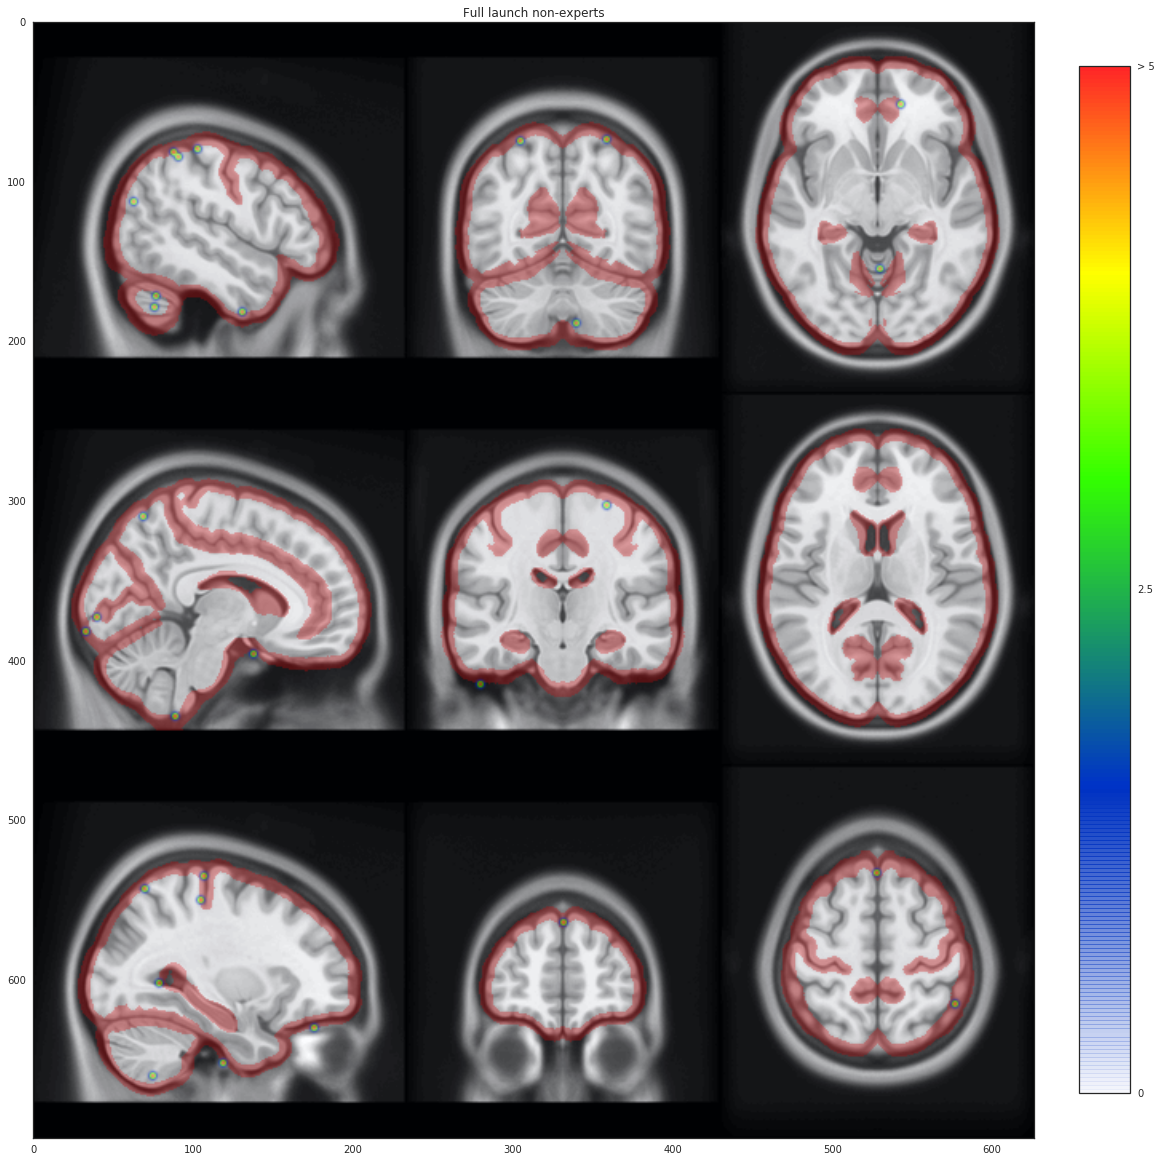

In [83]:
from heatmappy import Heatmapper
from PIL import Image
patches=list()
for ind, row in df_ids_imgnm.iterrows():
    out_tmp = out[out['ID'] == row.ID]
    patches.append([(row.x,row.y) for ind,row in out_tmp.iterrows()])
# plot heat map on the template
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111)
img = Image.open(os.path.join(path_root,'tutorial_v2/anat_fail/anat_template_stereotaxic.png'))
ax.set_title('Full launch non-experts')
patches = [x for x in sum(patches,[]) if str(x[0]) != 'nan'] 
heatmapper = Heatmapper(opacity=0.5,
                        point_diameter=8,
                        point_strength = 0.2,
                        colours=a)
heatmap = heatmapper.heatmap_on_img(patches, img)
im = ax.imshow(heatmap,cmap=coll_r)
cbar = fig.colorbar(im, orientation='vertical', ticks=[0, 125, 255],fraction=0.046, pad=0.04)
cbar.ax.set_yticklabels(['0', '2.5', '> 5'])
img.close()
heatmap.close()

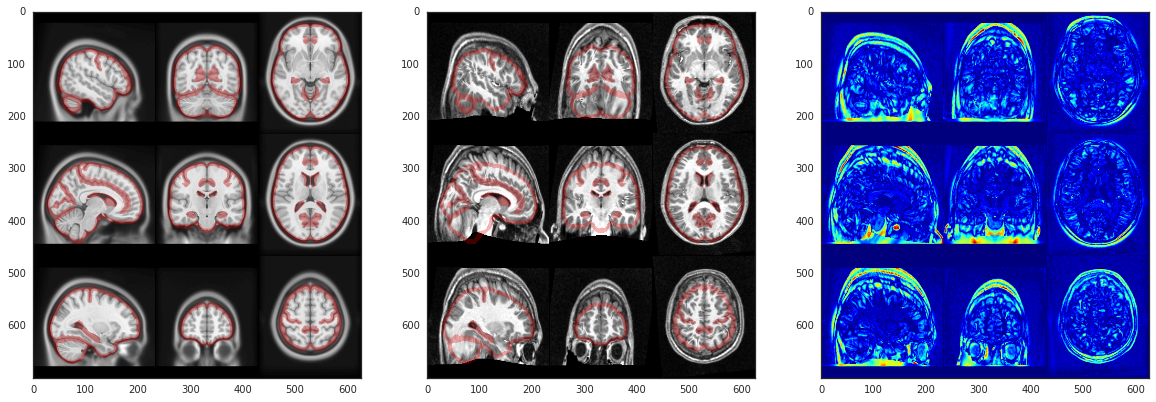

In [109]:
import pylab
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
img1 = mpimg.imread(os.path.join(path_root,'tutorial_v2/anat_fail/anat_template_stereotaxic.png'))
img2 = mpimg.imread(os.path.join(base_path_dest,'X_0021014_anat.png'))

# Calculate the absolute difference on each channel separately
error_r = np.fabs(np.subtract(img2[:,:,0], img1[:,:,0]))
error_g = np.fabs(np.subtract(img2[:,:,1], img1[:,:,1]))
error_b = np.fabs(np.subtract(img2[:,:,2], img1[:,:,2]))

# Calculate the maximum error for each pixel
lum_img = np.maximum(np.maximum(error_r, error_g), error_b)

# Uncomment the next line to turn the colors upside-down
#lum_img = np.negative(lum_img);

fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(131)
ax1.imshow(img1)
ax2 = fig.add_subplot(132)
ax2.imshow(img2)
ax3 = fig.add_subplot(133)
ax3.imshow(lum_img,cmap='jet')
# Choose a color palette
#ax3.set_cmap('Spectral') 
